In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import random

import seaborn

from commpy.filters import rrcosfilter
from scipy.signal import convolve

from scipy.stats import kurtosis, moment
from scipy.interpolate import interp1d

In [3]:
# specify the filename
INNAME = 'wfm.csv'
TRIALS = 100

In [4]:
# open the generated waveform as a pandas object
wave = pd.read_csv(INNAME, header=2)

In [5]:
# get the wave components
m1 = wave['Y1'].to_numpy()
m2 = wave['Y4'].to_numpy()

The following sampling function uses scipy interp1d (with the default linear interpolation) to reconstruct data of the same frequency with a given sampling rate and interval.

In [6]:
# gets n samples spaced with period T, starting at a random time
# makes sure the signal wraps properly
def sample(signal, T, n, start = None,interp=False):
    idx = np.arange(n)
    
    if (start==None):
        start = random.randint(0,len(signal))
    idx = idx*T+start
    idx1 = idx%len(signal)
    # doing the wrapping via modulus
    if (not interp):
        return np.array(signal[idx1])
    
    func = interp1d(idx,signal[idx1])
    
    ts = np.arange((n-1)*T+1)+start
#     ts = ts%len(signal)
    
    return func(ts)

In [7]:
# testing
sample(m1,2,10)

array([-0.042805, -0.138354, -0.23097 , -0.318849, -0.400286, -0.473709,
       -0.537711, -0.591077, -0.632809, -0.662141])

In [16]:
# get a numpy array of m sets of samples
def samples(signal,T,n,m):
    l = signal.size
#     print(l)
    rands = np.random.randint(0,l,size=m)
    samps = np.array([sample(signal,T,n,r,interp=False) for r in rands])
    return samps

In [9]:
# get the mean of the desired moment of the samples
def stats_no_var(signal,T,n,m,mom=None):
    s = samples(signal,T,n,m)
    if (mom!=None):
        return np.mean(moment(s,mom,axis=1))
    return [np.mean(moment(s,2,axis=1)),np.mean(moment(s,4,axis=1))]

In [10]:
# get var of the desired moment of the samples
def stats(signal,T,n,m,mom=None):
    s = samples(signal,T,n,m)
#     print(s)
    if (mom!=None):
        return np.var(moment(s,mom,axis=1))
    return [np.var(moment(s,2,axis=1)),np.var(moment(s,4,axis=1))]

In [11]:
stats(m1,T=10,n=3,m=100,mom=2)

0.0006819188869559608

Simulation:
Plotting over a range of n (number of samples) and T (period between the samples). Optionally add noise beforehand.

In [88]:
# DO THE SIM
# get our samples and plot var for diff ns and ts
NRANGE = 10000
ninc = 250
TRANGE = 100
tinc = 2

SIGNAL = m1-m2
M = 10

# applying across range
var = []
kur = []
for n in range(2*ninc,NRANGE,ninc):
    a = []
    b = []
    if (n%(ninc)==0):
        print(n)
    for t in range(2*tinc,TRANGE,tinc):
#         print(t)
        ss = stats(SIGNAL,t,n,M)
        a.append(ss[0])
        b.append(ss[1])
    var.append(np.array(a))
    kur.append(np.array(b))
var=np.array(var)
kur=np.array(kur)

500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750


In [12]:
# Graph the var(kurtosis) across ns and Ts
plt.imshow(kur, cmap='hot', interpolation='nearest')
plt.xlabel('T (period)')
plt.ylabel('n (number of samples)')
plt.title('Var(Kurtosis) with varying number and spacing of samples')
# fig, ax = plt.subplots()

l = np.arange(2*ninc,NRANGE,ninc)
w_ticks = 10
ticks = np.arange(0,(len(l)-1)//w_ticks+1)
ticks = ticks*w_ticks

plt.yticks(ticks,l[ticks])

l2 = np.arange(2*tinc,TRANGE,tinc)
w2_ticks = 10
ticks2 = np.arange(0,(len(l2)-1)//w2_ticks+1)
ticks2 = ticks2*w2_ticks

plt.xticks(ticks2,l2[ticks2])
# ax.set_xticklabels(np.arange(2*ninc,NRANGE,ninc))
# ticks,labels = plt.xticks()
# plt.xticks(range(2*ninc,NRANGE,ninc))
plt.show()

# Graph the var(variance) across ns and Ts
plt.imshow(var, cmap='hot', interpolation='nearest')
plt.xlabel('T (period)')
plt.ylabel('n (number of samples)')
plt.title('Var(Variance) with varying number and spacing of samples')
# fig, ax = plt.subplots()

plt.yticks(ticks,l[ticks])
plt.xticks(ticks2,l2[ticks2])

# ax.set_xticklabels(np.arange(2*ninc,NRANGE,ninc))
# ticks,labels = plt.xticks()
# plt.xticks(range(2*ninc,NRANGE,ninc))
plt.show()

NameError: name 'kur' is not defined

We see a very high variance when T = 46 or T = 92. This might be due to some artifact of the interaction of sampling time with length of the data set, though the signal has 523008 data points which is not a multiple of 46.
This got less prominent when we did interpolation

-39
-37
-35
-33
-31
-29
-27
-25
-23
-21
-19
-17
-15
-13
-11
-9
-7
-5
-3
-1
1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37


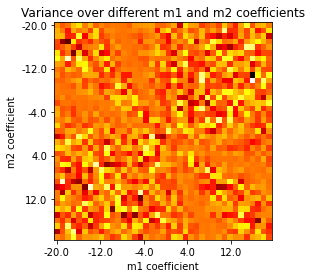

-39
-37
-35
-33
-31
-29
-27
-25
-23
-21
-19
-17
-15
-13
-11
-9
-7
-5
-3
-1
1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37


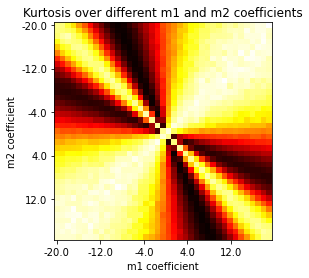

In [28]:
# LOOK AT THESE STATS OVER DIFFERENT MIXES
test_t = 25
test_n = 10000
mom = 2
M = 400

w = 39 # density of plots, make it odd
r = 20 # width of actual range

a = []
for i in range(-w,w,2):
    b = []
    print(i)
    for j in range(-w,w,2):
        m = m1*r/w*j+m2*r/w*i
        norm = np.linalg.norm(m)
        if (norm!=0):
            m=m/norm
        b.append(stats_no_var(m,test_t,test_n,M,mom))
    a.append(np.array(b))
a = np.array(a)

plt.yticks(np.arange(0,w,w/5),np.arange(-r,r,2*r/5))
plt.xticks(np.arange(0,w,w/5),np.arange(-r,r,2*r/5))

plt.title('Variance over different m1 and m2 coefficients')
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.xlabel('m1 coefficient')
plt.ylabel('m2 coefficient')
plt.show()

mom=4
a = []
for i in range(-w,w,2):
    b = []
    print(i)
    for j in range(-w,w,2):
        m = m1*r/w*j+m2*r/w*i
        norm = np.linalg.norm(m)
        if (norm!=0):
            m=m/norm
        b.append(stats_no_var(m,test_t,test_n,M,mom))
    a.append(np.array(b))
a = np.array(a)

plt.yticks(np.arange(0,w,w/5),np.arange(-r,r,2*r/5))
plt.xticks(np.arange(0,w,w/5),np.arange(-r,r,2*r/5))

plt.title('Kurtosis over different m1 and m2 coefficients')
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.xlabel('m1 coefficient')
plt.ylabel('m2 coefficient')
plt.show()

We see that the highest var mix is 1:-1, and the lowest var mix is 1:1

10
20
30
40
50
60
70
80
90


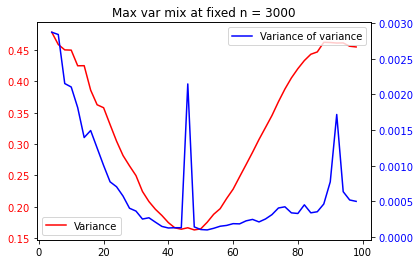

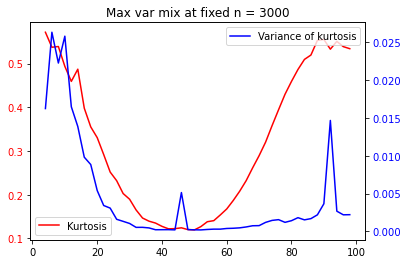

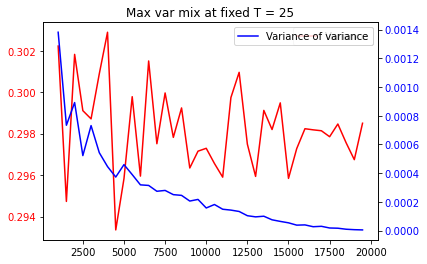

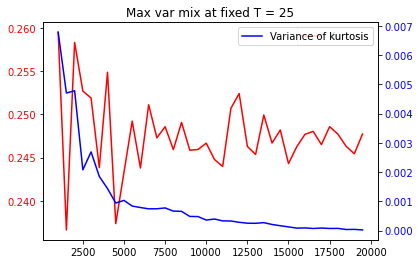

In [97]:
# graph var and kur at different sampling rates and periods
num_samp = 3000
samp_gap = 25
MAX_SIGNAL = m1-m2 # max variance and kur mix is 1:-1
MIN_SIGNAL = m1+m2 # min variance and kur mix is 1:1

M = 50

NRANGE = 20000
ninc = 500
TRANGE = 100
tinc = 2

# vary the time gap
def statistic_var_t(signal,signal_name = None):
    var = []
    kur = []
    vvar = []
    vkur = []
    for t in range(2*tinc,TRANGE,tinc):
        if (t%(tinc*5)==0):
            print(t)
        va = stats(signal,t,num_samp,M)
        a = stats_no_var(signal,t,num_samp,M)
        
        var.append(np.array(a[0]))
        kur.append(np.array(a[1]))
        vvar.append(np.array(va[0]))
        vkur.append(np.array(va[1]))
        
    l = np.arange(2*tinc,TRANGE,tinc)
    
    # plot variance and vvariance
    fig,ax = plt.subplots()
    ax.plot(l,var,color='red',label='Variance')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(l,vvar,color='blue',label='Variance of variance')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend()

# ax2.set_yscale('log')
    plt.xlabel("T (period)")
    plt.title(str(signal_name)+" at fixed n = "+str(num_samp))
    plt.show()
    
    
    # plot kur and vkur
    fig,ax = plt.subplots()
    ax.plot(l,kur,color='red',label='Kurtosis')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(l,vkur,color='blue',label='Variance of kurtosis')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend()

# ax2.set_yscale('log')
    plt.xlabel("T (period)")
    plt.title(str(signal_name)+" at fixed n = "+str(num_samp))
    plt.show()

def statistic_var_n(signal,signal_name = None):
    var = []
    kur = []
    vvar = []
    vkur = []
    for n in range(2*ninc,NRANGE,ninc):
        va = stats(signal,samp_gap,n,M)
        a = stats_no_var(signal,samp_gap,n,M)
        
        var.append(np.array(a[0]))
        kur.append(np.array(a[1]))
        vvar.append(np.array(va[0]))
        vkur.append(np.array(va[1]))
        
    l = np.arange(2*ninc,NRANGE,ninc)
#     w_ticks = 10
#     ticks = np.arange(0,(len(l)-1)//w_ticks+1)
#     ticks = ticks*w_ticks
    
    # plot variance and vvariance
    fig,ax = plt.subplots()
    ax.plot(l,var,color='red',label='Variance')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(l,vvar,color='blue',label='Variance of variance')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend()

# ax2.set_yscale('log')
    plt.xlabel("n (number of samples)")
    plt.title(str(signal_name)+" at fixed T = "+str(samp_gap))
    plt.show()
    
    
    # plot kur and vkur
    fig,ax = plt.subplots()
    ax.plot(l,kur,color='red',label='Kurtosis')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(l,vkur,color='blue',label='Variance of kurtosis')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend()

# ax2.set_yscale('log')
    plt.xlabel("n (number of samples)")
    plt.title(str(signal_name)+" at fixed T = "+str(samp_gap))
    plt.show()
    
statistic_var_t(MAX_SIGNAL,'Max var mix')
# statistic_var_t(MAX_SIGNAL,'Min var mix')
statistic_var_n(MAX_SIGNAL,'Max var mix')
# statistic_var_n(MAX_SIGNAL,'Min var mix')